<a href="https://colab.research.google.com/github/SuyeonSim/Data-analystic-Project/blob/main/03_AOV_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [9]:
import pandas as pd

# 저장했던 중간 데이터 불러오기
df_product = pd.read_csv('modori_preprocessed_items.csv')
df_aov = pd.read_csv('modori_preprocessed_orders.csv')

# 날짜 컬럼은 불러오면 다시 문자열이 되므로, 분석 전에 다시 datetime으로 변환해줍니다.
df_aov['주문일자'] = pd.to_datetime(df_aov['주문일자'])

print("🚀 분석용 데이터 로드 완료! 객단가 분석을 시작합니다.")

🚀 분석용 데이터 로드 완료! 객단가 분석을 시작합니다.


### **최근 1년 객단가 분석**

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 1. 날짜 데이터 형식 변환 및 기준일 설정
df_aov['주문일자'] = pd.to_datetime(df_aov['주문일자'])
analysis_end_date = df_aov['주문일자'].max() # 데이터상의 마지막 주문일 기준
analysis_start_date = analysis_end_date - pd.DateOffset(years=1)

# 2. 최근 1년 데이터 필터링
df_aov_1y = df_aov[df_aov['주문일자'] >= analysis_start_date].copy()

# 3. 금액 구간(Bins) 및 라벨 설정
max_val = df_aov_1y['총 결제금액'].max()
bins = [0, 10000, 30000, 70000, 100000, 130000, 160000, 200000, 300000, 400000, max_val + 1]
labels = ['0-1만원', '1-3만원', '3-7만원', '7-10만원', '10-13만원', '13-16만원', '16-20만원', '20-30만원', '30-40만원', '40만원 이상']

# 4. 데이터 구간화 (Binning)
df_aov_1y['금액구간'] = pd.cut(df_aov_1y['총 결제금액'], bins=bins, labels=labels, right=False)

# 5. 구간별 통계 집계
segment_1y = df_aov_1y.groupby('금액구간', observed=True).agg(
    주문건수=('주문번호', 'count'),
    총매출액=('총 결제금액', 'sum'),
    평균결제액=('총 결제금액', 'mean')
).reset_index()

# 6. 비중 및 누적비중 계산
total_count = segment_1y['주문건수'].sum()
segment_1y['비중(%)'] = (segment_1y['주문건수'] / total_count * 100).round(2)
segment_1y['누적비중(%)'] = segment_1y['비중(%)'].cumsum().round(2)

# 7. 결과 출력
print(f"📅 분석 기간: {analysis_start_date.date()} ~ {analysis_end_date.date()}")
print(f"📊 최근 1년 주문 데이터 기준 전략적 금액 구간 분석")
display(segment_1y)

📅 분석 기간: 2025-01-21 ~ 2026-01-21
📊 최근 1년 주문 데이터 기준 전략적 금액 구간 분석


,금액구간,주문건수,총매출액,평균결제액,비중(%),누적비중(%)
0,1-3만원,1,23911,23911.0,7.69,7.69
1,3-7만원,2,133727,66863.5,15.38,23.07
2,7-10만원,1,74247,74247.0,7.69,30.76
3,10-13만원,1,122878,122878.0,7.69,38.45
4,13-16만원,3,420102,140034.0,23.08,61.53
5,20-30만원,3,768207,256069.0,23.08,84.61
6,30-40만원,1,370166,370166.0,7.69,92.30
7,40만원 이상,1,593892,593892.0,7.69,99.99


In [11]:
import pandas as pd

# 1. 금액 구간 정보를 전체 상품 데이터에 매핑
# 주문번호를 기준으로 df_aov_1y의 '금액구간' 컬럼을 df_product와 병합합니다.
df_product_segment = pd.merge(
    df_product,
    df_aov_1y[['주문번호', '금액구간']],
    on='주문번호',
    how='inner'
)

# 2. 금액 구간별 상품 판매 빈도 집계
# 구간별로 어떤 상품이 가장 많이 팔렸는지 카운트합니다.
segment_product_stats = df_product_segment.groupby(['금액구간', '주문상품명'], observed=True).size().reset_index(name='판매건수')

# 3. 구간별 판매량 기준 내림차순 정렬 및 상위 5개 추출
segment_product_stats = segment_product_stats.sort_values(['금액구간', '판매건수'], ascending=[True, False])
top_products_by_segment = segment_product_stats.groupby('금액구간').head(5)

# 4. 결과 출력
print("📊 금액 구간별 인기 구매 상품 Top 5 (최근 1년)")
for segment in top_products_by_segment['금액구간'].unique():
    print(f"\n[{segment} 구간]")
    display(top_products_by_segment[top_products_by_segment['금액구간'] == segment].reset_index(drop=True))

📊 금액 구간별 인기 구매 상품 Top 5 (최근 1년)

[1-3만원 구간]


/tmp/ipython-input-664170512.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_products_by_segment = segment_product_stats.groupby('금액구간').head(5)


,금액구간,주문상품명,판매건수
0,1-3만원,무선 핸디 청소기,1



[3-7만원 구간]


,금액구간,주문상품명,판매건수
0,3-7만원,데일리 캔버스 토트백,1
1,3-7만원,미니멀리스트 식기세트,1
2,3-7만원,우드 그레인 조리도구,1
3,3-7만원,프리미엄 리넨 앞치마,1



[7-10만원 구간]


,금액구간,주문상품명,판매건수
0,7-10만원,프리미엄 리넨 앞치마,1



[10-13만원 구간]


,금액구간,주문상품명,판매건수
0,10-13만원,무선 핸디 청소기,1
1,10-13만원,올라운드 세라믹 냄비,1



[13-16만원 구간]


,금액구간,주문상품명,판매건수
0,13-16만원,스마트 에어 써큘레이터,2
1,13-16만원,데일리 캔버스 토트백,1
2,13-16만원,에코 프렌들리 가습기,1
3,13-16만원,프리미엄 리넨 앞치마,1



[20-30만원 구간]


,금액구간,주문상품명,판매건수
0,20-30만원,우드 그레인 조리도구,2
1,20-30만원,스마트 에어 써큘레이터,1
2,20-30만원,에코 프렌들리 가습기,1
3,20-30만원,프리미엄 리넨 앞치마,1



[30-40만원 구간]


,금액구간,주문상품명,판매건수
0,30-40만원,우드 그레인 조리도구,1



[40만원 이상 구간]


,금액구간,주문상품명,판매건수
0,40만원 이상,오가닉 코튼 타월세트,1


In [12]:
import pandas as pd
from itertools import combinations
from collections import Counter

# 1. 분석 대상 데이터 필터링 (최근 1년 및 2개 이상 품목 주문)
# df_aov_1y에 포함된 주문번호만 사용하며, 상품이 2개 이상인 주문만 추출합니다.
target_orders = df_product[ df_product['주문번호'].isin(df_aov_1y['주문번호'])]
order_item_lists = target_orders.groupby('주문번호')['주문상품명'].apply(list)
multi_item_orders = order_item_lists[order_item_lists.apply(len) >= 2]

# 2. 주문별 상품 조합(Pairs) 생성 및 카운트
# 한 주문 내의 상품들을 2개씩 짝지어 빈도를 계산합니다.
combo_counter = Counter()

for items in multi_item_orders:
    # 상품명 정렬을 통해 (A, B)와 (B, A)가 중복 집계되는 것을 방지합니다.
    combos = combinations(sorted(set(items)), 2)
    combo_counter.update(combos)

# 3. 결과 데이터프레임 생성
bundle_df = pd.DataFrame(combo_counter.most_common(15), columns=['상품조합', '빈도수'])
bundle_df['상품 1'] = bundle_df['상품조합'].apply(lambda x: x[0])
bundle_df['상품 2'] = bundle_df['상품조합'].apply(lambda x: x[1])

# 4. 결과 출력
print("📊 최근 1년 가장 빈번한 상품 조합 Top 15")
display(bundle_df[['상품 1', '상품 2', '빈도수']].reset_index(drop=True))

📊 최근 1년 가장 빈번한 상품 조합 Top 15


,상품 1,상품 2,빈도수
0,스마트 에어 써큘레이터,에코 프렌들리 가습기,1
1,데일리 캔버스 토트백,우드 그레인 조리도구,1
2,스마트 에어 써큘레이터,프리미엄 리넨 앞치마,1
3,무선 핸디 청소기,올라운드 세라믹 냄비,1
4,우드 그레인 조리도구,프리미엄 리넨 앞치마,1
5,미니멀리스트 식기세트,프리미엄 리넨 앞치마,1
6,데일리 캔버스 토트백,스마트 에어 써큘레이터,1


In [13]:
import pandas as pd
from itertools import combinations
from collections import Counter

# 1. 구간별 상품 조합 분석 함수 정의
def get_top_bundles(group):
    # 한 주문 내의 상품들을 리스트로 묶음
    order_items = group.groupby('주문번호')['주문상품명'].apply(list)
    # 2개 이상 품목을 구매한 주문만 필터링
    multi_item_orders = order_items[order_items.apply(len) >= 2]

    combo_counter = Counter()
    for items in multi_item_orders:
        # 중복 방지를 위해 정렬 후 조합 생성
        combos = combinations(sorted(set(items)), 2)
        combo_counter.update(combos)

    # 상위 3개 조합 반환
    return combo_counter.most_common(3)

# 2. 금액 구간별로 그룹화하여 분석 실행
print("📊 금액 구간별 주요 상품 합구매 조합 (Top 3)")

for segment in labels:
    # 해당 구간 데이터 필터링
    segment_data = df_product_segment[df_product_segment['금액구간'] == segment]

    if segment_data.empty:
        continue

    bundles = get_top_bundles(segment_data)

    print(f"\n[{segment} 구간]")
    if bundles:
        bundle_list = []
        for (combo, count) in bundles:
            bundle_list.append({'상품 조합': f"{combo[0]} + {combo[1]}", '빈도수': count})
        display(pd.DataFrame(bundle_list))
    else:
        print("분석 가능한 합구매 데이터가 없습니다.")

📊 금액 구간별 주요 상품 합구매 조합 (Top 3)

[1-3만원 구간]
분석 가능한 합구매 데이터가 없습니다.

[3-7만원 구간]


,상품 조합,빈도수
0,데일리 캔버스 토트백 + 우드 그레인 조리도구,1
1,미니멀리스트 식기세트 + 프리미엄 리넨 앞치마,1



[7-10만원 구간]
분석 가능한 합구매 데이터가 없습니다.

[10-13만원 구간]


,상품 조합,빈도수
0,무선 핸디 청소기 + 올라운드 세라믹 냄비,1



[13-16만원 구간]


,상품 조합,빈도수
0,스마트 에어 써큘레이터 + 프리미엄 리넨 앞치마,1
1,데일리 캔버스 토트백 + 스마트 에어 써큘레이터,1



[20-30만원 구간]


,상품 조합,빈도수
0,스마트 에어 써큘레이터 + 에코 프렌들리 가습기,1
1,우드 그레인 조리도구 + 프리미엄 리넨 앞치마,1



[30-40만원 구간]
분석 가능한 합구매 데이터가 없습니다.

[40만원 이상 구간]
분석 가능한 합구매 데이터가 없습니다.


### **시각화**

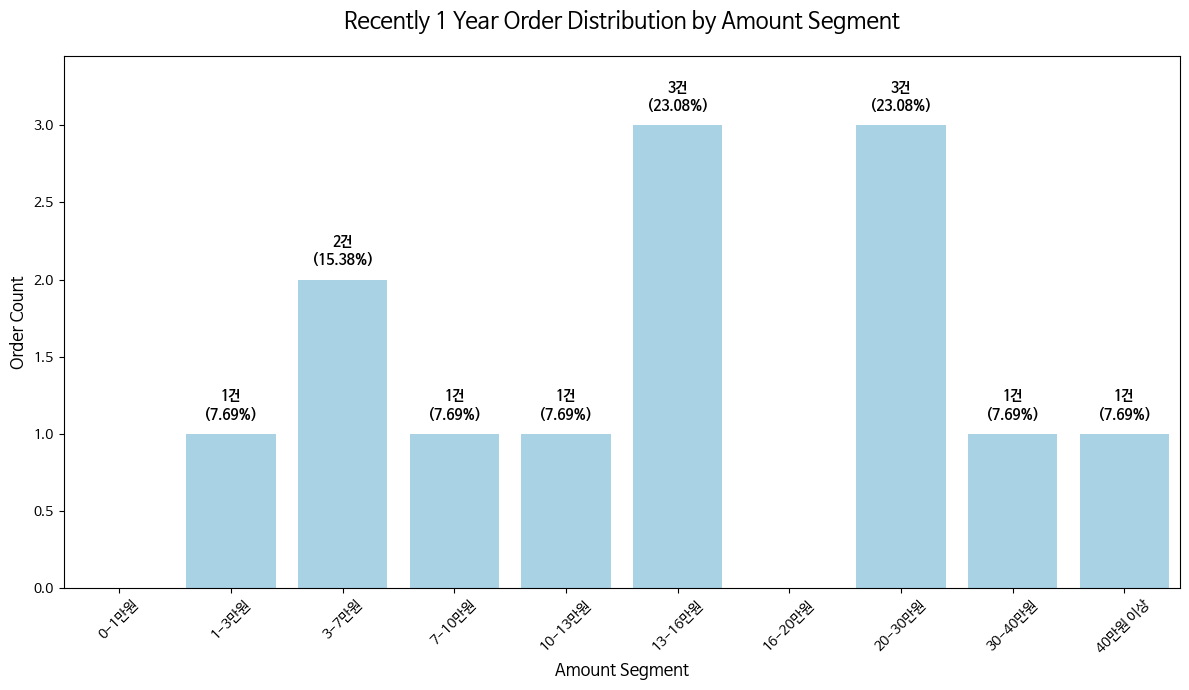

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')


# 1. 최근 1년 객단가 시각화
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=segment_1y, x='금액구간', y='주문건수', color='skyblue', alpha=0.8)

# 차트 제목 및 라벨 설정
plt.title('Recently 1 Year Order Distribution by Amount Segment', fontsize=16, pad=20)
plt.xlabel('Amount Segment', fontsize=12)
plt.ylabel('Order Count', fontsize=12)
plt.xticks(rotation=45)

# 바 상단에 비중(%) 라벨 표시
for i, p in enumerate(ax.patches):
    count = segment_1y.iloc[i]['주문건수']
    percent = segment_1y.iloc[i]['비중(%)']

    # f-string을 사용하여 건수와 비중을 결합 (콤마 포맷팅 포함)
    label = f"{int(count):,}건\n({percent}%)"

    ax.annotate(label,
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom',
                 fontsize=10,
                 fontweight='bold',
                 xytext=(0, 8),
                 textcoords='offset points')

# y축 범위를 텍스트가 잘리지 않게 살짝 높임
plt.ylim(0, segment_1y['주문건수'].max() * 1.15)


plt.tight_layout()
plt.savefig('aov_distribution.png')
plt.show()